## Problem Description:

Filippo's gang wrote a [paper](https://arxiv.org/pdf/2310.12730.pdf) on reconstructing multiplex networks from partial information. 

We are given a multiplex network with two layers $G^{\alpha} = \{\mathcal{N}^{\alpha},\mathcal{E}^{\alpha} \}$ 
and $G^{\beta} = \{\mathcal{N}^{\beta},\mathcal{E}^{\beta} \}$.
Being a multiplex, we assume $\mathcal{N} = \mathcal{N}^{\alpha} =\mathcal{N}^{\beta}$. We exclude the possibility that any edge $e_{ij}$ belongs to both layers simultaneously i.e.
 $ \nexists i,j \in \mathcal{E}^{\alpha},\mathcal{E}^{\beta} \mid e_{ij}^{\alpha} = e_{ij}^{\beta} \neq 1$.  
The problem is then given $e_{ij}^{\mathcal{x}} = 1$ in the aggregated graph  $G^{\alpha} \cup G^{\beta}$, is $\mathcal{x} = \alpha \, or\, \beta$

The workflow of their paper is to start with a single layer network with partial observation of true layer membership. Construct each part's embedding separately. Extract some specific features. Train logistic regression to classify edges between two layers. 
![Local Image](schematic_workflow.png)


* Can we use alt_means?
* Suppose we use partial info, can we not extract features or use alt_means to do better?
* Can we do away with using any partial information?
* Can we predict the number of layers in network?


If we are using two embeddings for each layer then how can we compare embeddings between layers?

### First attempt. Just run entire network on alt_means.
Instead of ground truth of communities. We have two labels indicating the layer of edge. But first, alt_means which gives node communities, has to be changed to give edge communities.

alt_means when given a set of vectors will give the communities it belongs to. So we don't need to modify it. We only need to create edge embeddings from the network. (That doesn't seem to be trivial)

Suppose we had to use node embeddings. How would it work here given that both layers have same set of nodes? How do we distinguish the distance between two nodes to be due to the fact that they're connected in layer alpha(/beta) or they're not related.

What if we make each node in a transformed graph (G2) to correspond to an edge in original graph (G1) and if two edges shared a node in G1 then the nodes in G2 corresponding to those edges share an edge. I think is supposed to be bipartite. If we have only two layers, will the embedding of this network make it easier?

This is a decent hypothesis

Let's create a line graph from an aggregated network

We generate network layers using the LancichinettiFortunato-Radicchi (LFR) model. We begin by generating an instance of the LFR model with a given set of parameters. We fix the value of the community size power-law exponent τ = 1.0 and the maximum degree kmax = √N for both layers. We vary the degree exponent γ and the mixing parameter µ, although we consider only experiments where these parameters are identical for both layers. Instead, we vary the average degree ⟨k^(α)⟩ and ⟨k^(β)⟩ at the level of the individual layers. We do
not impose any constraints on the size and number of communities. The two network layers are generated independently, thus edge overlap and correlation among the layer-wise community structures are negligible. If any edge is shared by the two layers, we remove it from the system.

### Create two independent layers of LFR Network

In [35]:
import lfr
import networkx as nx
import math
import random

def create_network(params= {
                                "N": 1000,     # number of nodes
                                "k": 6,       # average degree
                                "maxk": 30 ,   # maximum degree sqrt(10*N)
                                "minc": 5,    # minimum community size
                                "maxc": 50,   # maximum community size sqrt(10*N)
                                "tau": 4,    # degree exponent
                                "tau2": 1.0,   # community size exponent
                                "mu": 0.1,     # mixing rate
                            }):
    ng = lfr.NetworkGenerator()
    data = ng.generate(**params)

    net = data["net"]                  # scipy.csr_sparse matrix
    community_table = data["community_table"]  # pandas DataFrame
    seed = data["seed"]                # Seed value
    return net, community_table, seed

net={}
community_table={}
net[1],community_table[1],_ = create_network()
net[2],community_table[2],_ = create_network()
net[1] = nx.from_scipy_sparse_array(net[1])
net[2] = nx.from_scipy_sparse_array(net[2])

### Create an aggregated multilayer network

In [56]:


def calculate_edge_overlap(graph1, graph2):
    # Extract edge sets from the graphs
    edges1 = set(graph1.edges())
    edges2 = set(graph2.edges())

    # Calculate edge overlap
    overlap = edges1.intersection(edges2)
    print(len(overlap), "overlapping edges")
    return overlap

def randomly_remove_shared_edges(graph1, graph2, overlap):
    # Create copies of the original graphs to avoid modifying them directly
    graph1_copy = graph1.copy()
    graph2_copy = graph2.copy()

    # Randomly remove shared edges
    for edge in overlap:
        if random.choice([True, False]):
            graph1_copy.remove_edge(*edge)
        else:
            graph2_copy.remove_edge(*edge)

    return graph1_copy, graph2_copy


def create_aggregated_graph(graph1, graph2, label1='1', label2='2'):
    # Create a new graph for aggregation
    aggregated_graph = nx.Graph()

    # Add edges from graph1 with label
    for edge in graph1.edges():
        aggregated_graph.add_edge(edge[0], edge[1], layer=label1)

    # Add edges from graph2 with label
    for edge in graph2.edges():
        aggregated_graph.add_edge(edge[0], edge[1], layer=label2)

    return aggregated_graph


def create_multi_layer_network(graph1,graph2):
    overlap = calculate_edge_overlap(graph1, graph2)
    new_graph1, new_graph2 = randomly_remove_shared_edges(graph1, graph2, overlap)
    aggregated_graph = create_aggregated_graph(new_graph1, new_graph2)

    return aggregated_graph


graph1 = nx.Graph([(1, 2), (2, 3), (3, 1)])
graph2 = nx.Graph([(2, 3), (3, 4), (4, 2)])

aggregated_graph = create_multi_layer_network(graph1,graph2)
print("Aggregated Graph Edges:")
for edge in aggregated_graph.edges(data=True):
    print(edge)


1 overlapping edges
Aggregated Graph Edges:
(1, 2, {'layer': '1'})
(1, 3, {'layer': '1'})
(2, 3, {'layer': '2'})
(2, 4, {'layer': '2'})
(3, 4, {'layer': '2'})


### Convert network to its line graph

In [123]:
import pandas as pd

def create_line_graph(aggregated_graph):
    line_graph = nx.line_graph(aggregated_graph)
    communities = {(node1,node2): int(data['layer']) for node1,node2, data in aggregated_graph.edges(data=True)}
    # nx.set_node_attributes(line_graph, communities,name='layer')
    # Commenting this out in case embedding uses this information
    community_table = pd.DataFrame(list(communities.items()), columns=['edge', 'community_id'])
    community_table['line_node_name'] = range(len(community_table))

    mapping = dict(zip(community_table['edge'], community_table['line_node_name']))
    line_graph = nx.relabel_nodes(line_graph, mapping)

    H = nx.Graph()
    H.add_nodes_from(sorted(line_graph.nodes(data=True)))
    H.add_edges_from(line_graph.edges(data=True))
    
    net_line_scipy = nx.to_scipy_sparse_array(H)
    #community_table['community_id']= community_table['community_id'].astype(int)
    return net_line_scipy, community_table




### Now we are ready to apply alt-means
We create an embedding for the network, and then cluster the vectors

In [85]:
import sys
sys.path.append("/nobackup/gogandhi/alt_means_sans_k/")
from scripts.similarity_scores import clustering_method_values
from scripts.nets_and_embeddings import create_embedding

emb_params = {
                "method": "node2vec",
                "window_length": 10,
                "walk_length": 80,
                "num_walks": 10,
                "dim" : 64,
                }


# net_line, layer_table, emb
#modifying layer_table to be acceptable in alt_means
score_keys = ['proposed', 'kmeans', 'optics', 'dbscan','infomap']
device_name = "cuda:3"

net_agg = create_multi_layer_network(net[1],net[2])
net_line, community_table = create_line_graph(net_agg)
emb = create_embedding(net_line, emb_params)
scores = clustering_method_values(net_line, community_table,emb, score_keys, device_name)

scores

### Why is this not working?
Clustering works, so it's got to be that the line graph did not give good edge embeddings. Let's visualize the embeddings to see if it's the case.

/nobackup/gogandhi/miniconda3/envs/kmeans_env/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[1, 2]


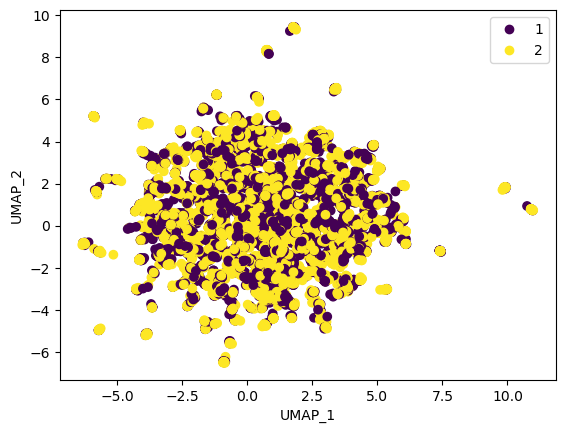

In [126]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

def umap_plot(data, clusters):
    #clusters= clusters.replace(2, 0, inplace=True)
    embedding = umap.UMAP(random_state=42, metric="euclidean").fit_transform(data) # Use cosine metric too

    s = plt.scatter(embedding[:, 0], embedding[:, 1], c = clusters, cmap = 'viridis')
    plt.xlabel('UMAP_1')
    plt.ylabel('UMAP_2')
    plt.legend(s.legend_elements()[0], list(set(clusters)))
    print(list(set(clusters)))
    #plt.title('UMAP clustering of 4406 cells', fontsize=20)
    plt.show()
    return

umap_plot(emb, community_table['community_id'])

Okay, so it looks like the embedding did not capture the two layer structure. It maybe because the edges in the two layers are independent of each other, and when they are aggregated, they lose information. In the paper, they had a training set of ground truth information which was usd to create two embeddings, each for the remnant network of each layer. 